<a href="https://colab.research.google.com/github/SimoneChiominto/TDA_grenoble/blob/main/BrainNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain functional network project


## Packages
First we import some libraries that will be useful in the project

### Install

In [ ]:
!pip install -U giotto-tda

     |████████████████████████████████| 1.5 MB 4.2 MB/s 
     |████████████████████████████████| 38.1 MB 1.3 MB/s 
     |████████████████████████████████| 404 kB 54.0 MB/s 
     |████████████████████████████████| 3.1 MB 45.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


### Import

In [ ]:
from numba import jit #utilising this library to speed up numpy computation
import numpy as np
import networkx as nx
import math
from networkx import tree
import scipy.special as ss
import gtda as gtda
from gtda.homology import VietorisRipsPersistence, SparseRipsPersistence, FlagserPersistence
from igraph import Graph
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

## Random Graph generation

### Erdos-Renyi
In this section we create a correlation matrix where for each threshold we generate an Erdos-Renyi graph.
This correlation matrix is symmetric, positive and has null diagonal. Each element in the upper triangle is genated from an uniform [0,1] distribution. 

There we create a function where we create an Erdos-renyi correlation matrix 

In [ ]:
def generate_Erdos_Renyi_correlation_matrix(n, seed=np.nan):
  # preallocate output
  corr_matrix=np.zeros([n,n])
  
  # generate random correlation

  # set seed
  if not np.isnan(seed):
     rng=np.random.default_rng(seed)
  else:
    rng=np.random.default_rng() 
  # generate upper triangle
  for i in range(0,n-1):
    for j in range(i+1,n):
      corr_matrix[i,j]=rng.uniform()
  
  # generate whole matrix
  corr_matrix=corr_matrix+ corr_matrix.transpose()

  return corr_matrix 

  

Simple example to see if the function is working

In [ ]:
generate_Erdos_Renyi_correlation_matrix(5)

array([[0.        , 0.09650849, 0.27348446, 0.32694251, 0.30826027],
       [0.09650849, 0.        , 0.14155196, 0.07234424, 0.57565805],
       [0.27348446, 0.14155196, 0.        , 0.45995284, 0.90732899],
       [0.32694251, 0.07234424, 0.45995284, 0.        , 0.47697383],
       [0.30826027, 0.57565805, 0.90732899, 0.47697383, 0.        ]])

### Lattice WRONG
Now, we want to do the same as before but for lattice network. The idea is to use networkx for creating a grid graph, then extract the adjacency matrix and then where we see 1 we generate a random number. 


#### First method from grid graph
Below there are 3 functions needed to generate a random correlation matric for lattice graphs.
- **generate_nd_lattice(dim)**: given the dimensions it gives a complete grid graph
- **adjacency_to_correlation (A, seed=np.nan)**: a general function that given a adjacency matrix it gives a correlation matrix where each link is $\sim$ Unif(0,1).
- **generate_lattice_correlation_matrix(dim, seed=np.nan)**: It is the function that we want to use to generate a random correlation matrix for lattice graph. It uses the two preceding functions

In [ ]:
def generate_nd_lattice (dim): #genera lattice con le corrispondenti dimensioni
  lattice = nx.grid_graph(dim)
  lattice = nx.to_numpy_array(lattice)
  return lattice
#we can figure out lattice dimensions by roughly superimposing a rectangular grid over a human brain and figuring out estimate proportions

In [ ]:
def adjacency_to_correlation (A, seed=np.nan): # genera corr matrix da qualsiasi adjacency
  
  #set seed
  if not np.isnan(seed):
    rng=np.random.default_rng(seed)
  else:
    rng=np.random.default_rng() 
  #generate random uniform correlation
  A=np.triu(A)
  length=sum(sum(A==1))
  A[A==1]=rng.uniform(0,1,length)
  A=A+A.transpose()
  return A

In [ ]:
def generate_lattice_correlation_matrix(dim, seed=np.nan):
  complete_lattice = generate_nd_lattice(dim)
  random_lattice = adjacency_to_correlation(complete_lattice, seed)
  return random_lattice


Simple example

[[0. 1. 1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 1. 1. 0.]]
[[0.         0.80500292 0.80794079 0.         0.51532556 0.
  0.         0.        ]
 [0.80500292 0.         0.         0.28580138 0.         0.0539307
  0.         0.        ]
 [0.80794079 0.         0.         0.38336888 0.         0.
  0.40847321 0.        ]
 [0.         0.28580138 0.38336888 0.         0.         0.
  0.         0.04527519]
 [0.51532556 0.         0.         0.         0.         0.04875771
  0.99917612 0.        ]
 [0.         0.0539307  0.         0.         0.04875771 0.
  0.         0.65236911]
 [0.         0.         0.40847321 0.         0.99917612 0.
  0.         0.2345102 ]
 [0.         0.         0.         0.04527519 0.         0.65236911
  0.2345102  0.        ]]


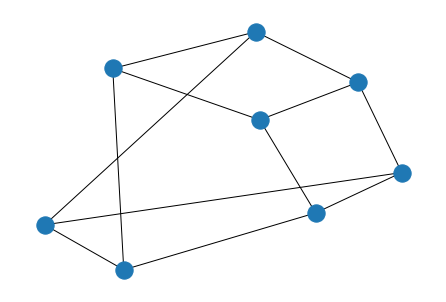

In [ ]:
A=generate_nd_lattice([2,2,2])
print(A)
A=adjacency_to_correlation(A,5)
print(A)
nx.draw(nx.from_numpy_matrix(A))

### Lattice
The first method might be wrong. Lattice shold be connected to the nearest k nodes, not as a grid. We have to do it again

In [ ]:
def generate_ring_lattice_correlation_matrix(n, seed=np.nan):
  
  max_edge=n*(n-1)/2
  
  # preallocate output
  corr_matrix=np.zeros([n,n])
  
  # generate random correlation
  # set seed
  if not np.isnan(seed):
     rng=np.random.default_rng(seed)
  else:
    rng=np.random.default_rng() 


  G=nx.watts_strogatz_graph(n, 2, 0)
  G_adjacency=nx.to_numpy_array(G)
  G_adjacency=np.triu(G_adjacency) 
  length=sum(sum(G_adjacency==1))
  G_adjacency[G_adjacency==1]=rng.uniform(1-length/max_edge,1,length)
  a=1-length/max_edge
  
  corr_matrix+=G_adjacency

  for k in range(1,int(np.floor(n/2))):
    #creo ring lattice con 2*k e 2*(k+1) edges
    G=nx.watts_strogatz_graph(n, 2*k, 0)
    H=nx.watts_strogatz_graph(n, 2*(k+1), 0)
    H_adjacency=nx.to_numpy_array(H)
    G_adjacency=nx.to_numpy_array(G)
    diff_adjacency=H_adjacency-G_adjacency
    diff_adjacency=np.triu(diff_adjacency)
    # prendo la differenza, conto quanti sono
    diff_adjacency=H_adjacency-G_adjacency
    diff_adjacency=np.triu(diff_adjacency)
  
    length=sum(sum(diff_adjacency==1))
    #faccio unif nella parte nell'intervallo dalla fine del precedente a la porzione di nodi da inserire rispetto al totale
    diff_adjacency[diff_adjacency==1]=rng.uniform(a-length/max_edge,a,length)
    a=a-length/max_edge
    corr_matrix+=diff_adjacency

  return corr_matrix+np.transpose(corr_matrix)

I had some problems installing cechmate, maybe it is not possible to use it. In that case i think I have to read https://giotto-ai.github.io/gtda-docs/latest/notebooks/persistent_homology_graphs.html#undirected-graphs-vietorisripspersistence-and-sparseripspersistence and maje the graph such that the filtration becames automatic

### Small world
now, we want to generate correlation matrices for small world graph from watts_strogatz_graph.

In [ ]:
@jit()
def generate_small_world_correlation_matrix(n,p, seed=np.nan):
  max_edge=n*(n-1)/2
  
  # preallocate output
  corr_matrix=np.zeros([n,n])
  
  # generate random correlation

  # set seed
  if not np.isnan(seed):
     rng=np.random.default_rng(seed)
  else:
    rng=np.random.default_rng() 
    seed=0 #da modificare


  G=nx.watts_strogatz_graph(n, 2, p,seed)
  G_adjacency=nx.to_numpy_array(G)
  G_adjacency=np.triu(G_adjacency) 
  length=sum(sum(G_adjacency==1))
  G_adjacency[G_adjacency==1]=rng.uniform(1-length/max_edge,1,length)
  a=1-length/max_edge
  
  corr_matrix+=G_adjacency

  for k in range(1,int(np.floor(n/2))):
    #creo ring lattice con 2*k e 2*(k+1) edges
    G=nx.watts_strogatz_graph(n, 2*k, p,seed)
    H=nx.watts_strogatz_graph(n, 2*(k+1), p,seed)
    H_adjacency=nx.to_numpy_array(H)
    G_adjacency=nx.to_numpy_array(G)
    diff_adjacency=H_adjacency-G_adjacency
    diff_adjacency=np.triu(diff_adjacency)
    # prendo la differenza, conto quanti sono
    diff_adjacency=H_adjacency-G_adjacency
    diff_adjacency=np.triu(diff_adjacency)
  
    length=sum(sum(diff_adjacency==1))
    #faccio unif nella parte nell'intervallo dalla fine del precedente a la porzione di nodi da inserire rispetto al totale
    diff_adjacency[diff_adjacency==1]=rng.uniform(a-length/max_edge,a,length)
    a=a-length/max_edge
    corr_matrix+=diff_adjacency

  return corr_matrix+np.transpose(corr_matrix)


## From correlation matrix to graph
In this section we want to create a function that generate an adjency matrix from a correlation matrix given a specified threshold. We would like to have a connected graph, therefore we use a function provided to us that add to the initially created graph a spanning tree that does not modify homological properties of the graph




In [ ]:
def adj_matrix_notconncted(corr_matrix, eps):#this function it is not used, but maybe it will be useful in the future
  cond=corr_matrix<1-eps
  adj_matrix=np.zeros(np.shape(corr_matrix))
  adj_matrix[np.where(cond)]=0
  adj_matrix[np.where(np.logical_not(cond))]=1
  return adj_matrix


In [ ]:
@jit()
def adj_matrix_connected(corr_matrix,sparsity_value):
    """
    given the correlation matrix and the expected sparsity coefficient it can 
    happen that the corresponding thresholded matrix results in a disconnected graph
    here we force the graph to be fully connected by the computation of the minimum
    spanning tree and adding the required edges in order to have a unique connected component 
    """
    if sparsity_value == 1.0:
        adj_matrix=np.ones(corr_matrix.shape)
        np.fill_diagonal(adj_matrix,0)
        return adj_matrix
        
    #aggiungere l'errore se lo sparsity value è troppo basso
    
    corr_matrix =abs(corr_matrix)

    max_num_edges = ss.comb(corr_matrix.shape[0],2)
    num_edges = int(max_num_edges*sparsity_value)
    
    num_regions=corr_matrix.shape[0]
    #total number of regions in the graph


    totalgraph=nx.from_numpy_matrix(1-abs(corr_matrix))
    #extraction of a complete graph having has weight 1-abs(correlation)
    #we need to take 1-abs since the mst is taking the minimum weight graph and we want the most correlated edges to be there
    
    MST=nx.adjacency_matrix(tree.minimum_spanning_tree(totalgraph).to_undirected()).todense()
    MST_adj_mat=MST #inutile
    MST_adj_mat[MST>0]==1 #inutile
    MST_adj_mat=np.triu(MST_adj_mat) #put zeros in the inferior triangular matrix
    
    #put zeros in the diagonal of the corr matrix
    for i in range(num_regions):
        corr_matrix[i,i]=0
    
    values_corr=abs(np.triu(corr_matrix)) #forse abs inutile
    
    cor_wo_MST=values_corr[np.triu(MST_adj_mat)==0]
    #we do not consider the correlation values which do not involve edges that are already in the MST
        #we consider the correlation values which do not involve edges that are already in the MST ???
    values=list(cor_wo_MST.flatten())
    values.sort(reverse=True)
    
    #we select the maximum value of correlation to have the expected num of edges - num of edges in the mst (num regions-1)
    # values must have at least 1 element: AT LEAST 1 LINK MORE THAN  THE  SPANNING TREE
    value_thresh=values[min(num_edges-(num_regions-1),len(values))-1] #-1 index start at 0
    #notice, we can't choose a sparsity value resulting in a nuber of edges lower than then number of edges in the spanning tree (sparsity value tree  = 2*(n-1)/(n-1)*n = 1*2/n)
    adj_matrix=np.zeros(corr_matrix.shape) 
    
    #we put an edge if the value of correlation is higher than the found threshold or if the edges is required by the mst
    adj_matrix[values_corr>=value_thresh]=1
    adj_matrix[MST_adj_mat!=0]=1
    
    adj_matrix=(adj_matrix)+np.transpose((adj_matrix)) #simmetry of the adj matrix
    
    return adj_matrix


The function above, gives some problems when the sparsity value is too little. An example follows.

<ipython-input-29-00f6cf815520>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "adj_matrix_connected" failed type inference due to: No implementation of function Function(<built-in function abs>) found for signature:
 
 >>> abs(array(float64, 2d, C))
 
There are 4 candidate implementations:
    - Of which 2 did not match due to:
    Type Restricted Function in function 'abs': File: unknown: Line unknown.
      With argument(s): '(array(float64, 2d, C))':
     No match for registered cases:
      * (int8,) -> int8
      * (int16,) -> int16
      * (int32,) -> int32
      * (int64,) -> int64
      * (uint8,) -> uint8
      * (uint16,) -> uint16
      * (uint32,) -> uint32
      * (uint64,) -> uint64
      * (float32,) -> float32
      * (float64,) -> float64
      * (complex64,) -> float32
      * (complex128,) -> float64
    - Of which 2 did not match due to:
    Overload of function 'abs': File: numba/core/typing/npdatetime.py: Li

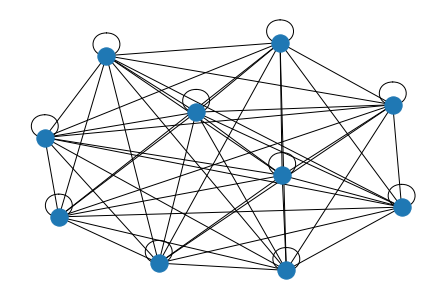

In [ ]:
G=generate_Erdos_Renyi_correlation_matrix(10,10)

nx.draw(nx.from_numpy_matrix(adj_matrix_connected(G,0.1)))

## Extracting filtration from correlation matrices
in this section we want to make a filtration from correlation matrices. The idea is to increase the threshold $ɛ$ in order to create more and more connected graphs. Given each graph $G_ɛ$ we want to write it as a simplicial complex, therefore we have to find the cliques trhough networkx

### generate_graph_sequence()
This is the function generating the graph sequence needed for the filtration

In [ ]:
@jit()
def generate_graph_sequence(corr_matrix, costs):


  # input:
  #   correlation matrix: is the correlation matrix where we need to extract 
  #                       using the function provided to us
  #   costs: is the list of cost where we decided to make the filtration
  # output:
  #   graph_sequence: it is a list of numpy matrices, each being an adjacency 
  #                   matrix of a graph of hte filtration
  
  graph_sequence=list()
  for eps in costs:
    graph_sequence.append(adj_matrix_connected(corr_matrix,eps))
  return graph_sequence



below some exaples, it seems to work even though the problem with the function adj_matrix_connected() remains.

<ipython-input-31-5bfd9e0ed268>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "generate_graph_sequence" failed type inference due to: Invalid use of type(CPUDispatcher(<function adj_matrix_connected at 0x7f271464d320>)) with parameters (array(float64, 2d, C), float64)

During: resolving callee type: type(CPUDispatcher(<function adj_matrix_connected at 0x7f271464d320>))
During: typing of call at <ipython-input-31-5bfd9e0ed268> (15)


File "<ipython-input-31-5bfd9e0ed268>", line 15:
def generate_graph_sequence(corr_matrix, costs):
    <source elided>
  for eps in costs:
    graph_sequence.append(adj_matrix_connected(corr_matrix,eps))
    ^

  @jit()
<ipython-input-31-5bfd9e0ed268>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "generate_graph_sequence" failed type inference due to: cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "<ipython-inp

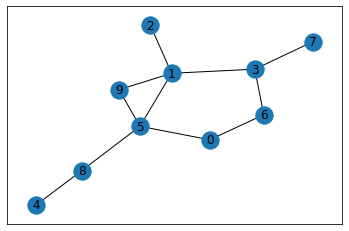

In [ ]:
G=generate_Erdos_Renyi_correlation_matrix(10,0)
costs=np.linspace(0,1,21)
graph_filtration=generate_graph_sequence(G,costs)
#for example: in this case we had no problem from 5 up, 4 becames a strange graph
nx.draw_networkx(nx.from_numpy_matrix(graph_filtration[5]))

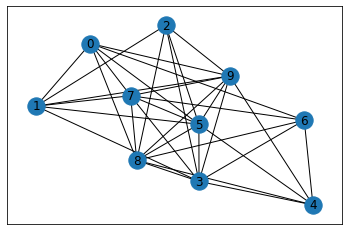

In [ ]:
nx.draw_networkx(nx.from_numpy_matrix(graph_filtration[15]))

Examples with random lattice



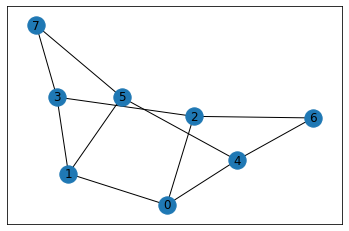

In [ ]:
G=generate_lattice_correlation_matrix([2,2,2],0)
costs=np.linspace(0,1,21)
graph_filtration=generate_graph_sequence(G,costs)
#for example: in this case it works only between 6 and 9
nx.draw_networkx(nx.from_numpy_matrix(graph_filtration[8]))

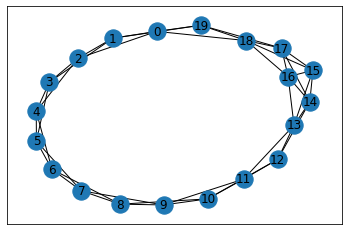

In [ ]:
C=generate_ring_lattice_correlation_matrix(20,1)
costs=np.linspace(1/9,1,100)
graph_filtration=generate_graph_sequence(C,costs)
nx.draw_networkx(nx.from_numpy_matrix(graph_filtration[13]))


<ipython-input-27-e0b9d99be811>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "generate_small_world_correlation_matrix" failed type inference due to: Untyped global name 'sum': cannot determine Numba type of <class 'builtin_function_or_method'>

File "<ipython-input-27-e0b9d99be811>", line 21:
def generate_small_world_correlation_matrix(n,p, seed=np.nan):
    <source elided>
  G_adjacency=np.triu(G_adjacency) 
  length=sum(sum(G_adjacency==1))
  ^

  @jit()
<ipython-input-27-e0b9d99be811>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "generate_small_world_correlation_matrix" failed type inference due to: Untyped global name 'sum': cannot determine Numba type of <class 'builtin_function_or_method'>

File "<ipython-input-27-e0b9d99be811>", line 21:
def generate_small_world_correlation_matrix(n,p, seed=np.nan):
    <source elided>
  G_adjacency=np.triu(G_adjacency) 
  lengt

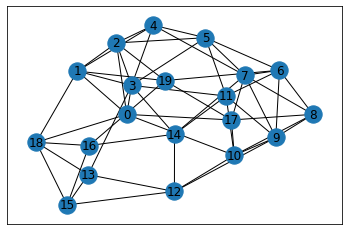

In [ ]:
C=generate_small_world_correlation_matrix(20,0.05,1)
costs=np.linspace(1/9,1,100)
graph_filtration=generate_graph_sequence(C,costs)
nx.draw_networkx(nx.from_numpy_matrix(graph_filtration[20]))

### generate_complex_filtration()
From the list of graph we want to have a list of simplicial complexes. This is done in the following function

It does not seem to be useful

In [ ]:
@jit()
def generate_complex_filtration(graph_sequence):
  # input:
  #   graph_sequence: it is the graph sequence in the filtration we are 
  #                   interested in
  # output:
  #   complex_sequence: it is a list of list of arrays, each being a clique for 
  #                     a graph in the sequence
  complex_sequence=list()
  for graph in graph_sequence:
    complex_sequence.append(list(nx.find_cliques(nx.from_numpy_matrix(graph))))
  return complex_sequence

we continue the example made before, it seems all coherent.

In [ ]:
G=generate_Erdos_Renyi_correlation_matrix(10,0)
costs=np.linspace(0,1,21)
graph_filtration=generate_graph_sequence(G,costs)
complex_filtration=generate_complex_filtration(graph_filtration)
print(complex_filtration[5])
print(complex_filtration[6])

<ipython-input-37-26c01dabad98>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "generate_complex_filtration" failed type inference due to: Unknown attribute 'find_cliques' of type Module(<module 'networkx' from '/usr/local/lib/python3.7/dist-packages/networkx/__init__.py'>)

File "<ipython-input-37-26c01dabad98>", line 11:
def generate_complex_filtration(graph_sequence):
    <source elided>
  for graph in graph_sequence:
    complex_sequence.append(list(nx.find_cliques(nx.from_numpy_matrix(graph))))
    ^

During: typing of get attribute at <ipython-input-37-26c01dabad98> (11)

File "<ipython-input-37-26c01dabad98>", line 11:
def generate_complex_filtration(graph_sequence):
    <source elided>
  for graph in graph_sequence:
    complex_sequence.append(list(nx.find_cliques(nx.from_numpy_matrix(graph))))
    ^

  @jit()
<ipython-input-37-26c01dabad98>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting e

[[0, 5], [0, 6], [1, 9, 5], [1, 2], [1, 3], [4, 8], [6, 3], [7, 3], [8, 5]]
[[0, 8, 5], [0, 6], [1, 9, 5], [1, 2], [1, 3, 7], [4, 8], [6, 3]]


/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:178: NumbaWarning: Function "generate_complex_filtration" was compiled in object mode without forceobj=True.

File "<ipython-input-37-26c01dabad98>", line 10:
def generate_complex_filtration(graph_sequence):
    <source elided>
  complex_sequence=list()
  for graph in graph_sequence:
  ^

  state.func_ir.loc))
/usr/local/lib/python3.7/dist-packages/numba/core/object_mode_passes.py:188: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "<ipython-input-37-26c01dabad98>", line 10:
def generate_complex_filtration(graph_sequence):
    <source elided>
  complex_sequence=list()
  for graph in graph_sequence:
  ^

  state.func_ir.loc))


## Giotto
let's try to compute persistence homology with giotto 

### Creation of a adjacency graph for giotto
If we want to use the Vietoris Rips filtration from giotto we need to work on our adjacency graph. In particular the weigth need to represent the appearence of that link in the filtration.

In the function below, given a graph filtration we create that kind of adjacency matrix

In [ ]:
def from_filtration_to_adjacency(graph_filtration):
  
  # pre allocate output
  # we create an array with non feasible weigth
  adjacency_matrix=np.ones(np.shape(graph_filtration[0]))*(-1)

  # for each graph in the filtration if a new link appears, the weigth is the 
  # number of the filtration.
  for i,graph in enumerate(graph_filtration):
    cond=np.logical_and(adjacency_matrix==-1,graph==1)
    adjacency_matrix[cond]=i
  
  # diagonal entries need to be 0
  adjacency_matrix+= np.identity(np.shape(adjacency_matrix)[0])
  # all non feasible weight becomes infinite 
  adjacency_matrix[adjacency_matrix==-1]=np.inf
  return adjacency_matrix
    



Example on erdos renyi graph

In [ ]:
G=generate_Erdos_Renyi_correlation_matrix(90,1)
costs=np.linspace(1/44,1,100)
graph_filtration=generate_graph_sequence(G,costs)
adjacency_matrix=from_filtration_to_adjacency(graph_filtration)
adjacency_matrix

array([[ 0., 47.,  3., ..., 16., 82., 61.],
       [47.,  0., 67., ..., 60., 48., 98.],
       [ 3., 67.,  0., ..., 10., 67., 97.],
       ...,
       [16., 60., 10., ...,  0., 24.,  9.],
       [82., 48., 67., ..., 24.,  0., 53.],
       [61., 98., 97., ...,  9., 53.,  0.]])

### Computation of persistence homology
Here we define a function that given a list of correlation matrices return a list of persistence diagrams. 

In [ ]:
def custom_vietoris_persistance (corr_mats,costs,homology_dimensions,plot=False):
#qiesta è la versione che ho modificato, non riesco a stampare il grafico, cosa sbaglio??
  '''
  input:
    corr_mats:  correlation matrices of the graphs we want to compute the diagram
    costs:      list of the costs where the filtration is computed
    homology_dimensions: list of the dimensions of the homology to compute
    plot:       boolean value, if true this function plot the persistence graph 
  
  output:       
    diagrams: list of persistance diagrams. Each element of the list 
              is a list of points in the plane with associated dimansion
  '''  

  if isinstance(homology_dimensions, int):
    homology_dimensions=list(range(1,homology_dimensions+1))

  if not isinstance(corr_mats,list):
    corr_mats=[corr_mats]

  #generate filtrations
  graph_filtrations = [generate_graph_sequence(g,costs) for g in corr_mats]
  #generate adjacency matrices
  adjacency_matrices = [from_filtration_to_adjacency(graph_filtration) for graph_filtration in graph_filtrations]
  # Instantiate topological transformer
  VR = VietorisRipsPersistence(metric="precomputed",homology_dimensions=homology_dimensions)

  # Compute persistence diagrams corresponding to each graph in X
  diagrams = VR.fit_transform(adjacency_matrices)

  if (plot):
    VR.plot(diagrams, sample=0)
  
  return diagrams,VR

### Examples
In this section we compute some persistence diagrams with Giotto

#### Erdos-Renyi persistence diagram 
Here an example with Erdos-Renyi graph

In [ ]:
#generate correlation matrix
G=generate_Erdos_Renyi_correlation_matrix(90,1)
#generate filtration
costs=np.linspace(1/44,1,100)
graph_filtration=generate_graph_sequence(G,costs)
#compute adjacency matrix to be given to giotto
adjacency_matrix=from_filtration_to_adjacency(graph_filtration)
adjacency_matrix
# Instantiate topological transformer
VR = VietorisRipsPersistence(metric="precomputed",homology_dimensions=[ 1, 2,3,4])
adjacency_matrix=[adjacency_matrix]
# Compute persistence diagrams corresponding to each graph in X
diagrams = VR.fit_transform(adjacency_matrix)
VR.plot(diagrams, sample=0)

Let see how this homological properties are saved in *diagrams*

In [ ]:
#print(diagrams)
diagrams[0]

Diagrams are saved as a list of all the diagrams.
Each diagram is an array of array. Each Array inside the array represent a point of the diagram and it is represented with three floats (birth, death, dimension of homology). If two or more points coincide on the diagrams it is shown as multiplicity.

#### Lattice graph persistence diagram
Here an example with Lattice Graph

In [ ]:
G=generate_ring_lattice_correlation_matrix(90,1)
costs=np.linspace(1/44,1,100)
graph_filtration=generate_graph_sequence(G,costs)
adjacency_matrix=from_filtration_to_adjacency(graph_filtration)
#print(adjacency_matrix)
# Instantiate topological transformer
VR = VietorisRipsPersistence(metric="precomputed",homology_dimensions=[1, 2,3,4])
adjacency_matrix=[adjacency_matrix]
# Compute persistence diagrams corresponding to each graph in X
diagrams = VR.fit_transform(adjacency_matrix)
VR.plot(diagrams, sample=0)

#### Small-World persistence diagram
Here an example with a small world correlation graph

In [ ]:
G=generate_small_world_correlation_matrix(90,0.01,1)
costs=np.linspace(1/44,1,100)
graph_filtration=generate_graph_sequence(G,costs)
adjacency_matrix=from_filtration_to_adjacency(graph_filtration)
#print(adjacency_matrix)
# Instantiate topological transformer
VR = VietorisRipsPersistence(metric="precomputed",homology_dimensions=[1, 2,3,4])
adjacency_matrix=[adjacency_matrix]
# Compute persistence diagrams corresponding to each graph in X
diagrams = VR.fit_transform(adjacency_matrix)
VR.plot(diagrams, sample=0)

## Analysis of topological information over random graphs
In this section we edfine functions to examine topological informations of a given filtration. Specifically, we plot persistence diagrams, betti curves and (partial) Euler Entropy (by partial we mean that we're actually calculating the Euler characteristic only using the calculated betti numbers). Clearly the number still contains topological information


### Computing betti numbers

We want to separate the information of the different dimensions of the homology in different list.

In [ ]:
@jit()
def separate(diagrams):
  '''
  input:  
    dmg: persistence diagram from giotto 
  output: 
    H: list of different dimensions points in persistent diagrams
  '''
  H=[]

  for i,diagram in enumerate(diagrams):
    
    H.append([])
    #set of the dimensions of the points in the diagram
    dimensions=set(diagram[:,2])
    
    #for all the dimension i generate the list of the point of that exact dimension
    for j,dimension in enumerate(dimensions):
      H[i].append([])
      H[i][j]=[point for point in diagram if point[2]==dimension]
      H[i][j]=np.asarray(H[i][j])

  #if there is only one diagram there is no need of creating a list of list
  #if len(diagrams)==1:
  #  return H[0]

  return H

With the following function we compute the betti numbers for each graph in the filtration

In [ ]:
def betti_numbers (diagrams,n_filtration_steps): 
  '''
  input: 
    diagrams: persistence diagram from giotto 
    n_filtration_steps: it is the number of filtration steps
  output:
    betti_numbers: it is a list of matrix where each column represent a dimension 
        and the rows are the filtration steps
  '''
  separated_diagram=separate(diagrams)
  betti_numbers=[]
  for k,H in enumerate(separated_diagram):
    n_dimensions=len(H)   # number of different dimensions where we computed the homology
    betti_numbers.append(np.zeros(shape=(n_filtration_steps, n_dimensions)))

    for i in range(n_filtration_steps):
      for j in range(n_dimensions):
        born = H[j][:,0]<=i+1 #generator of the omology must be already born
        not_death = i+1 < H[j][:,1] #generator og the homology should not be already dead
        betti_numbers[k][i,j]=sum(np.logical_and(born, not_death))
  
  return betti_numbers

### Euler Characteristic

The following functions are based on enumerating all the cliques, this quickly becomes computationally intractable

In [ ]:
def euler_char_cliques(adj):
  #qua stiamo facendo forza bruta, magari possiamo calcolarci imparando dalle cricche della filtrazione precedente
  cliques=list(nx.enumerate_all_cliques(nx.from_numpy_matrix(adj))) # this should give the same value as its analogue w/ the betti numbers
  x=0
  dim_cliques=np.asarray([len(clique)-1 for clique in cliques])
  x=sum((-1)**dim_cliques)
 # for i in range(len(cliques)):
  #  x += ((-1)**(len(cliques[i])-1)) 
  return x

A=(adj_matrix_connected(G,0.222225))
print(euler_char_cliques(A))

206


In [ ]:
def euler_entropy_cliques(adj):
  return np.log(np.abs(euler_char_cliques(adj)))

With the following functions we only calculate the Euler characteristic based on the alternate sum of betti numbers' multiplicity calculated so far ( we don't usually go beyond dimension 4) (this may be actually wrong, yet the euler entropy calculated in this way still lines up properly w/ phase transitions)

In [ ]:
def euler_char_betti(betti):
  # problema, noi non ci siamo calcolati tutti tutti i numeri di betti, solo nelle dimensioni che abbiamo scelto, che se fa?
  x=0
  a = np.empty((len(betti)))
  a[::2] = 1
  a[1::2] = -1
  # a è un vettore con componenti (-1)^n
  x = np.sum(np.multiply(betti,a))
  return x



In [ ]:
def euler_entropy_betti(betti):
  return np.log(np.abs(euler_char_betti(betti)))

### Examples

In [ ]:
filtration_length=100

G=generate_small_world_correlation_matrix(90,0.02,1)
costs=np.linspace(1/44,1,filtration_length)
graph_filtration=generate_graph_sequence(G,costs)
adjacency_matrix=from_filtration_to_adjacency(graph_filtration)

# Instantiate topological transformer
VR = VietorisRipsPersistence(metric="precomputed",homology_dimensions=[1, 2,3,4])
adjacency_matrix=[adjacency_matrix]

# Compute persistence diagrams corresponding to each graph in X
diagrams = VR.fit_transform(adjacency_matrix)
VR.plot(diagrams, sample=0)

betti_number_small_world=betti_numbers(diagrams,filtration_length)[0]
entropy_small_world=[euler_entropy_betti(betti_number_small_world[i,:]) for i in range(filtration_length)] 
#for j in range(filtration_length):
 # x=betti_numbers(j+1,separate(diagrams))
 # y.append(x)
 # entropy.append(euler_entropy_betti(x))

In [ ]:

filtration_length=100
G=generate_Erdos_Renyi_correlation_matrix(90,1)
costs=np.linspace(1/44,1,filtration_length)
graph_filtration=generate_graph_sequence(G,costs)
adjacency_matrix=from_filtration_to_adjacency(graph_filtration)
#rint(adjacency_matrix)
# Instantiate topological transformer
VR = VietorisRipsPersistence(metric="precomputed",homology_dimensions=[1, 2,3])
adjacency_matrix=[adjacency_matrix]
# Compute persistence diagrams corresponding to each graph in X
diagrams = VR.fit_transform(adjacency_matrix)
VR.plot(diagrams, sample=0)

#save array to plot
betti_number_erdos_renyi=betti_numbers(diagrams,filtration_length)[0]
entropy_erdos_renyi=[euler_entropy_betti(betti_number_erdos_renyi[i,:]) for i in range(filtration_length)]  


In [ ]:
#calcola i betti numbers con moltiplicità dato il diagramma)
plt.plot(range(filtration_length),betti_number_small_world)
plt.plot(range(filtration_length),betti_number_erdos_renyi)
#plt.plot(range(filtration_length),y)
#plt.plot(range(filtration_length),erdos)
#y=[euler_entropy_cliques(graph) for graph in graph_filtration]
#plt.plot(range(filtration_length),entropy)
#betti_number
#entropy

In [ ]:
plt.plot(range(filtration_length),entropy_erdos_renyi)
plt.plot(range(filtration_length),entropy_small_world)


In [ ]:
s=30
filtration_length=100
#y1=[]
#y2=[]
#y3=[]
#euler=[]
#for i in range(s):
 # print(i)
f=lambda i: generate_small_world_correlation_matrix(90,(i+1)/s,1)
graphs=list(map(f,range(s)))
costs=np.linspace(1/44,1,filtration_length)
graph_filtrations=[generate_graph_sequence(g,costs) for g in graphs]
adjacency_matrices=[from_filtration_to_adjacency(graph_filtration) for graph_filtration in graph_filtrations]
adjacency_matrices
  #rint(adjacency_matrix)
  # Instantiate topological transformer
VR = VietorisRipsPersistence(metric="precomputed",homology_dimensions=[1, 2])
#adjacency_matrix=[adjacency_matrix]
  # Compute persistence diagrams corresponding to each graph in X
diagrams = VR.fit_transform(adjacency_matrices)
VR.plot(diagrams, sample=0)
  #for j in range(filtration_length):
  #  y1.append([j,(i+1)/s,betti_numbers(j+1,separate(diagrams))[0]])
  #  y2.append([j,(i+1)/s,betti_numbers(j+1,separate(diagrams))[1]])
  #  y3.append([j,(i+1)/s,betti_numbers(j+1,separate(diagrams))[2]])
  #  euler.append([j,(i+1)/s,euler_entropy_betti(betti_numbers(j+1,separate(diagrams)))])

In [ ]:
VR.plot([diagrams[9]], sample=0)
z=betti_numbers(diagrams,filtration_length)
entropy=[[euler_entropy_betti(betti_numbers_graph[i,:]) for i in range(filtration_length)] for betti_numbers_graph in z]  
entropy
z=np.asarray(z)
np.shape(z)
z=z.reshape((30*100,2))
#z[:,0]

In [ ]:

fig = plt.figure()
ax = plt.axes(projection='3d')
x=np.tile(np.asarray(range(filtration_length)),s)
#z=y[:,0]
y=np.repeat(np.linspace(1/s,1,s),filtration_length)
#print(x)
#print(y)
#print(z)
ax.scatter3D(x,y,z[:,0], cmap='Greens')

In [ ]:
(np.asarray(range(s))+1)/s
#np.asarray(range(filtration_length))

In [ ]:

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(np.transpose(y2)[0],np.transpose(y2)[1],np.transpose(y2)[2] , cmap='Greens')

In [ ]:

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(np.transpose(y3)[0],np.transpose(y3)[1],np.transpose(y3)[2] , cmap='Greens')

In [ ]:

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(entropy[0],entropy[1],entropy[2] , cmap='Greens')

## Brain correlation matrix


We clone the Github repo

In [1]:
!git clone https://gricad-gitlab.univ-grenoble-alpes.fr/carbonil/regional-differentiation-based-on-graph-nodal-statistics-for-functional-brain-connectivity-networks-characterization.git

Cloning into 'regional-differentiation-based-on-graph-nodal-statistics-for-functional-brain-connectivity-networks-characterization'...
remote: Enumerating objects: 1274, done.
remote: Total 1274 (delta 0), reused 0 (delta 0), pack-reused 1274
Receiving objects: 100% (1274/1274), 15.02 MiB | 10.00 MiB/s, done.
Resolving deltas: 100% (999/999), done.


### Importing correlation matrices
I'm trying to import the correlation matrices as pandas dataframes

In [3]:
import pandas as pd

In [4]:
import os

In [5]:
path="/content/regional-differentiation-based-on-graph-nodal-statistics-for-functional-brain-connectivity-networks-characterization/DATA/cor_mat_HCP_90"
files=os.listdir(path) #make a list of all the files' names at the path 
cor_mats_HCP_90_df=[pd.read_csv(path+"/"+file,delim_whitespace=True,header=None) for file in files]

Now I have imported all files in cor_mat_HCP_90. Let's do the same for the files in cor_mat_coma. They have a sligthly different structure

In [6]:
path="/content/regional-differentiation-based-on-graph-nodal-statistics-for-functional-brain-connectivity-networks-characterization/DATA/cor_mat_coma"
files=os.listdir(path) #make a list of all the files' names at the path 
cor_mats_coma_df=[pd.read_csv(path+"/"+file,delim_whitespace=True) for file in files]


Now we have imported all the correlation matrices as list of pandas dataframes.
Let's save them also as numpy arrays

In [ ]:
cor_mats_HCP_90=[df.to_numpy() for df in cor_mats_HCP_90_df]
cor_mats_coma=[df.to_numpy() for df in cor_mats_coma_df]

### Compute some persistence diagrams

There I compute the persistance diagrams of the cor_mats in coma and save it in the file /data.diagrams_coma

In [ ]:
costs=np.linspace(1/44,1, 100)
diagrams_coma,VR_coma=custom_vietoris_persistance(cor_mats_coma,costs,[1,2,3,4],plot=False)

In [ ]:
VR_coma.plot(diagrams_coma, sample=9)

Now I want to save this data using pickle

In [ ]:
import pickle

In [ ]:
with open("/data.diagrams_coma", "wb") as f:
  pickle.dump((diagrams_coma,VR_coma), f, protocol=pickle.HIGHEST_PROTOCOL)

NameError: ignored

In [ ]:
with open("/data.diagrams_coma", "rb") as f:
  (diagrams_coma,VR_coma)=pickle.load(f)

FileNotFoundError: ignored

Now, I'll do the same as before with the HTC_90 Folder

In [ ]:
costs=np.linspace(1/44,1, 100)
diagrams_HCP_90,VR_HCP_90=custom_vietoris_persistance(cor_mats_HCP_90,costs,[1,2,3,4],plot=False)

KeyboardInterrupt: ignored

In [ ]:
VR_HCP_90.plot(diagrams_HCP_90, sample=9)

In [ ]:
with open("/data.diagrams_HCP_90", "wb") as f:
  pickle.dump((diagrams_HCP_90,VR_HCP_90), f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open("/data.diagrams_HCP_90", "rb") as f:
  (diagrams_HCP_90,VR_HCP_90)=pickle.load(f)


In [ ]:
VR_HCP_90.plot(diagrams_HCP_90,sample=9)

# New code
This are parts we are still working on

In [ ]:
G=np.loadtxt("WAVECO~1.TXT",skiprows=0,dtype=float,usecols=range(0,90))
print((G))

[[1.         0.82769115 0.57917623 ... 0.47048196 0.6871404  0.69223374]
 [0.82769115 1.         0.50612392 ... 0.5312735  0.55749886 0.63544121]
 [0.57917623 0.50612392 1.         ... 0.61353392 0.70573595 0.55755186]
 ...
 [0.47048196 0.5312735  0.61353392 ... 1.         0.57111876 0.60343518]
 [0.6871404  0.55749886 0.70573595 ... 0.57111876 1.         0.75000928]
 [0.69223374 0.63544121 0.55755186 ... 0.60343518 0.75000928 1.        ]]


In [ ]:
def custom_vietoris_persistance_old (adjacency_matrix,filtration_length,dimensions,plot):
  #commenti:  - cambierei il nome della variabile da adjacency a correlation matrix
  #           - più che filtration_lenght passerei i costi
  #           - con dimensions passerei già la lista delle dimensioni da calcolare, 
  #             magari con una cosa che conrtolla se è o no una lista se è una lista
  #             fa da uno a o altrimenti dai i costi
  #           - la funzione deve essere resistente a passare liste di correlation matrices, 
  #             così sfruttiamo la possibilità di giotto di calcolarne più insieme, 
  #             probabilmente in quella maniera è ottimizzato
  costs=np.linspace(1/44,1,filtration_length)
  graph_filtration=generate_graph_sequence(adjacency_matrix,costs)
  adjacency_matrix=from_filtration_to_adjacency(graph_filtration)
  dim = list(range(1,dimensions+1))
  print(dim)
  # Instantiate topological transformer
  VR = VietorisRipsPersistence(metric="precomputed",homology_dimensions=dim)
  adjacency_matrix=[adjacency_matrix]

  # Compute persistence diagrams corresponding to each graph in X
  diagrams = VR.fit_transform(adjacency_matrix)
  if(plot):
    VR.plot(diagrams, sample=0)
  return diagrams

In [ ]:
def custom_vietoris_persistance (corr_mats,costs,homology_dimensions,plot):
#qiesta è la versione che ho modificato, non riesco a stampare il grafico, cosa sbaglio??
#sposterei questo pezzo nella parte dedicata a giotto
  '''
  input:
    corr_mats:  correlation matrices of the graphs we want to compute the diagram
    costs:      list of the costs where the filtration is computed
    homology_dimensions: list of the dimensions of the homology to compute
    plot:       boolean value, if true this function plot the persistence graph 
  
  output:       diagrams, list of persistance diagrams. Each element of the list 
                is a list of points in the plane with associated dimansion
  '''  

  if isinstance(homology_dimensions, int):
    homology_dimensions=list(range(1,homology_dimensions+1))

  if not isinstance(corr_mats,list):
    corr_mats=[corr_mats]

  #generate filtrations
  graph_filtrations = [generate_graph_sequence(g,costs) for g in corr_mats] #sbaglia qualcosa qua dentro! fa soltanto 2 step
  #generate adjacency matrices
  adjacency_matrices = [from_filtration_to_adjacency(graph_filtration) for graph_filtration in graph_filtrations]
  # Instantiate topological transformer
  VR = VietorisRipsPersistence(metric="precomputed",homology_dimensions=homology_dimensions)
  # Compute persistence diagrams corresponding to each graph in X
  diagrams = VR.fit_transform(adjacency_matrices)
  print(diagrams)

  if (plot):
    VR.plot(diagrams, sample=0)
  return diagrams

example for testing purposes

In [ ]:
diagrams=custom_vietoris_persistance([G,G],[0.1,0.2,0.3,0.4],2,plot=True)

[array([[0., 0., 2., ..., 3., 0., 0.],
       [0., 0., 3., ..., 2., 2., 1.],
       [2., 3., 0., ..., 1., 0., 2.],
       ...,
       [3., 2., 1., ..., 0., 2., 1.],
       [0., 2., 0., ..., 2., 0., 0.],
       [0., 1., 2., ..., 1., 0., 0.]]), array([[0., 0., 2., ..., 3., 0., 0.],
       [0., 0., 3., ..., 2., 2., 1.],
       [2., 3., 0., ..., 1., 0., 2.],
       ...,
       [3., 2., 1., ..., 0., 2., 1.],
       [0., 2., 0., ..., 2., 0., 0.],
       [0., 1., 2., ..., 1., 0., 0.]])]


(not)working example

In [ ]:
diagrams=custom_vietoris_persistance(G,[1/44,1],[1,2,3,4],plot=True)
#print(G)

[[[0. 0. 1.]
  [0. 0. 2.]
  [0. 0. 3.]
  [0. 0. 4.]]]


ValueError: ignored

In [ ]:
diagrams=custom_vietoris_persistance_old(G,100,4,plot=True)
#print(G)

[[1.         0.82769115 0.57917623 ... 0.47048196 0.6871404  0.69223374]
 [0.82769115 1.         0.50612392 ... 0.5312735  0.55749886 0.63544121]
 [0.57917623 0.50612392 1.         ... 0.61353392 0.70573595 0.55755186]
 ...
 [0.47048196 0.5312735  0.61353392 ... 1.         0.57111876 0.60343518]
 [0.6871404  0.55749886 0.70573595 ... 0.57111876 1.         0.75000928]
 [0.69223374 0.63544121 0.55755186 ... 0.60343518 0.75000928 1.        ]]
[1, 2, 3, 4]


In [ ]:
betti_number_brain1=betti_numbers(diagrams,100)
print(betti_number_brain1)

[array([[0., 0., 0., 0.],
       [2., 0., 0., 0.],
       [4., 0., 0., 0.],
       [8., 0., 0., 0.],
       [7., 0., 0., 0.],
       [8., 0., 0., 0.],
       [5., 0., 0., 0.],
       [4., 1., 0., 0.],
       [3., 0., 0., 0.],
       [3., 0., 0., 0.],
       [3., 0., 0., 0.],
       [2., 0., 0., 0.],
       [2., 1., 0., 0.],
       [2., 1., 0., 0.],
       [2., 1., 0., 0.],
       [2., 1., 0., 0.],
       [2., 1., 0., 0.],
       [2., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [2., 0., 0., 0.],
       [2., 0., 0., 0.],
       [2., 0., 0., 0.],
       [2., 0., 0., 0.],
       [2., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],

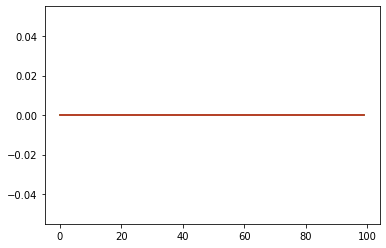

In [ ]:
#calcola i betti numbers con moltiplicità dato il diagramma)
plt.plot(range(100),betti_number_brain1[0])
#plt.plot(range(filtration_length),betti_number_erdos_renyi)
#plt.plot(range(filtration_length),y)
#plt.plot(range(filtration_length),erdos)
#y=[euler_entropy_cliques(graph) for graph in graph_filtration]
#plt.plot(range(filtration_length),entropy)
#betti_number
#entropy